# Final Assigmnet Advanced Spatial Analysis

This assigment uses data from Slovenia to calculate a soil erosion map. I order to calculate soil erosion, we use the revised universal soil loss equation (RUSLE) which is:

Soil loss = K-factor * R-factor * SL-factor * C-factor

In [ ]:
# Install no-yet-installed packages. These are the only packages you need, but you may add additional ones if you want. 
!pip install rasterio
!pip install rioxarray
!pip install rasterstats
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 3.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 7.8 MB 9.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.6 MB 6.9 MB/s 
     |████████████████████████████████| 139 kB 76.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.7 MB/s 


In [ ]:
# Import packages. These are teh suggested packages, but remember that tehre are always multiple solutions and yuo migth want to use other options. 
import rasterio                   
import numpy as np
import matplotlib.pyplot as plt
import rioxarray  
import geopandas as gpd
from rasterio.enums import Resampling
from rasterstats import zonal_stats
from numpy.random import randint

## Set path and Import data


In [43]:
# First connect to google drive for reading data and writing results.
from google.colab import drive 
drive.mount ("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# Paths to the data
LC_path = "/content/drive/MyDrive/DataPackage/LC_Slovenia.tif"
KF_path = "/content/drive/MyDrive/DataPackage/K_Slovenia.tif"
RF_path = "/content/drive/MyDrive/DataPackage/R_Slovenia.tif"
LS_path = "/content/drive/MyDrive/DataPackage/SL_Slovenia.tif" # There was a typo in the name of the file ("slovania" instead of "slovenia"). I changed the name of the file. Hope this is ok.
slovenia_path = "/content/drive/MyDrive/DataPackage/gadm41_SVN_2.shp"

In [47]:
# Read the data
slovenia= gpd.read_file(slovenia_path)
LC = rioxarray.open_rasterio(LC_path, masked=True)
K_factor = rioxarray.open_rasterio(KF_path, masked=True)
R_factor = rioxarray.open_rasterio(RF_path, masked=True)
SL_factor = rioxarray.open_rasterio(LS_path, masked=True)


## Preliminary

In this section I check the data by looking at the plots, as well as coordinate reference system (CRS), bounds, shapes, and resolution of all four datasets. If I want to multiply one raster with another, I need to make sure all these attributes are the same.

In [48]:
print(LC.rio.resolution())
print(K_factor.rio.resolution())
print(R_factor.rio.resolution())
print(SL_factor.rio.resolution())

(100.0, -100.0)
(500.0, -500.0)
(500.0, -500.0)
(100.0, -100.0)


In [49]:
new_resolution = 500
LC = LC.rio.reproject(LC.rio.crs, resolution= new_resolution, resampling = Resampling.mode)
SL_factor = SL_factor.rio.reproject(SL_factor.rio.crs, resolution= new_resolution, resampling = Resampling.mode)


In [50]:
print(LC.rio.crs)
print(K_factor.rio.crs)
print(R_factor.rio.crs)
print(SL_factor.rio.crs)
# All have the same coordinate reference system (CRS)

PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]
PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center"

In [51]:
print(LC.rio.bounds())
print(K_factor.rio.bounds())
print(R_factor.rio.bounds())
print(SL_factor.rio.bounds())
# The bounds of LC and SL are slightly different from the K and R factor. This is probably due to the chnage in the original resolution.

(4581200.0, 2488400.0, 4827700.0, 2660400.0)
(4581200.0, 2488800.0, 4827700.0, 2660800.0)
(4581200.0, 2488800.0, 4827700.0, 2660800.0)
(4581200.0, 2488400.0, 4827700.0, 2660400.0)


In [52]:
# I will use the reproject_match function. It reprojects the data to match the resolution, projection and bounds of the reference dataset.
LC = LC.rio.reproject_match(K_factor)
SL_factor = SL_factor.rio.reproject_match(K_factor)

In [53]:
slovenia.crs
# The shapefile has a different CRS than the rasters. I will reproject the shapefile to match the CRS of the rasters.
slovenia = slovenia.to_crs(LC.rio.crs)

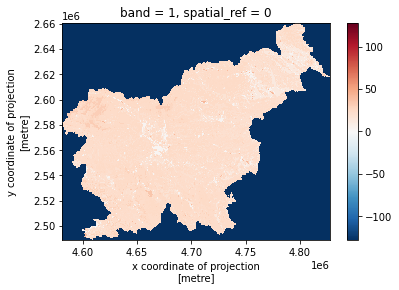

In [54]:
LC.plot()

In [55]:
# As seen in the plot, there are negative values assigned to pixels around Slovenia. I will replace these values with NaN.
LC = LC.where(LC >= 0, float('nan'))

Now we have finished checking the data, and doing all the necessary steps. 

## C-factor calculation

The four maps have the same resolution (500m), the same shape, same bounds, and the same Coordinate reference system (CRS). So we are ready to perfom raster calulations. We start with the cover factor (C-factor). 

The corine land cover clasess has 5 classes that are further divided into 15 subclasses, that are further divided into 44 groups. For the sake of simplicity, we assume that classes 1, 4 and 5 (Artifical surfaces, wetlands and waterbodies) have a C-factor of zero. These land cover classes have very little to no soil, and represent a small part of the total surface. 

For classes 2 and 3 (Agriculutral areas and Forest and seminatural areas), I use results from table 1 and table 2 in Panagos et al. (2015): "Estimating the soil erosion cover-management factor at the European scale". Table 1 concerns only arable land (rice, non-irrigated arable land, and permanently irrigated arable land). In order to avoid making the analysis excessively tedious, I will only calculate C-factors for all 15 subgroups (and not all 44 land cover classes). For the subgroup arable land, I will take a weighted average based on the crops in table 1. For the rest of the subclasses, I use table 2, which shows a range (min and max) of C-factors of different land uses cover classes (groups). I will take the average of the minimum and maximum value, and then take another average to get one number for each subgroup. 

In [57]:
no_soil_subclasses = 0 # classes 1, 4 and 5
arable_land = 0.28422
permanent_crops = 0.233
pastures = 0.1
heterogenous_agriculture = 0.1375
forest = 0.00155 # broadleaved, mixed and coniferous forest have the same value
shrubs_herbaceous = 0.052
open_spaces = 0.12

In [58]:
# Here I reassign the values of the land cover data to the values above
C_factor = LC.where((LC<1) | (LC>11), no_soil_subclasses)
C_factor = C_factor.where((LC<12) | (LC>14), arable_land)
C_factor = C_factor.where((LC<15) | (LC>17), permanent_crops)
C_factor = C_factor.where( LC!=18, pastures)
C_factor = C_factor.where((LC<19) | (LC>22), heterogenous_agriculture)
C_factor = C_factor.where((LC<23) | (LC>25), forest)
C_factor = C_factor.where((LC<26) | (LC>29), shrubs_herbaceous)
C_factor = C_factor.where((LC<30) | (LC>34), open_spaces)
C_factor = C_factor.where((LC<35) | (LC>44), no_soil_subclasses)
C_factor = C_factor.where(LC>0) # Masking potential no data values

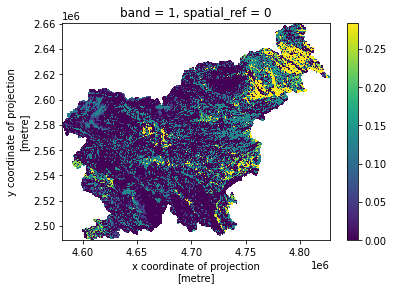

In [59]:
C_factor.plot()

In [60]:
# Calculate the average soil loss using RUSLE
soil_loss = C_factor * K_factor * R_factor * SL_factor

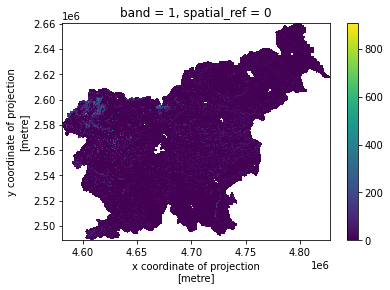

In [61]:
soil_loss.plot()

## Final output

This section we finalize by reporting the relevant output

In [62]:
# All regions code in the shapefile
regions_code_all = slovenia.loc[:,'HASC_2']
#Here I randomize to get the name of the regions. You can input the regions you want.
# Select two (or more) random regions
regions_code = regions_code_all.iloc[randint(len(slovenia), size = 6)]
regions = slovenia.loc[slovenia['HASC_2'].isin(regions_code)]

In [65]:
def output (regions, soil_loss):
    # calculations plot 1: share of area
    regions_area = regions.area / 10**6 # in km2
    # calculations plot 2: share of average soil loss
    soil_loss.rio.to_raster('soil_loss.tif') #Save as a raster the erosion results
    regions.to_file('regions.shp') #Save as a shp the Slovenia regions
    soil_loss_sum = zonal_stats('regions.shp', 'soil_loss.tif', stats = 'sum',nodata=np.nan)
    # In order to create a simple list with avg. soil loss values for each region
    soil_loss_list = []
    for i in range(len(soil_loss_sum)):
        soil_loss_list.append(list(soil_loss_sum[i].values())[0])
    # within this function, I want to create three subplots
    
    fig = plt.figure(figsize=(18,10), dpi=1600)
    if len(regions) < 11:
        ax1 = plt.subplot2grid((1,3),(0,0))
        plt.pie( regions_area, labels = regions['NAME_2'], autopct='%1.1f%%')
        plt.title('Share of area')
        ax1 = plt.subplot2grid((1,3),(0,1))
        plt.pie(soil_loss_list, labels = regions['NAME_2'], autopct='%1.1f%%')
        plt.title('Share of total soil erosion')
    else:
        ax1 = plt.subplot2grid((1,3),(0,0))
        plt.hist(soil_loss_list, bins = 7)
        plt.title('Histogram of soil erosion')
        plt.xlabel('Soil erosion (tons)') 
        ax1 = plt.subplot2grid((1,3),(0,1))
        plt.hist((soil_loss_list / (regions_area/10000)), bins = 7)
        plt.title('Histogram for erosion rate')
        plt.xlabel('Erosion rate (tons/hectare)')
    ax1 = plt.subplot2grid((1,3),(0,2))
    regions_area_list = regions_area.to_list() # to convert into iterable object
    for i in range(len(regions)):
        plt.scatter(regions_area_list[i], soil_loss_list[i], label = regions['NAME_2'].iloc[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Relationship between area and soil erosion')
        plt.xlabel('Area (km2)')
        plt.ylabel('Soil erosion (tons)')
    
    

In [66]:
output(regions, soil_loss) # This function takes a long time to run (>2 min), so please be patient! My computer is not the fastest one.

/usr/local/lib/python3.8/dist-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/usr/local/lib/python3.8/dist-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/usr/local/lib/python3.8/dist-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/usr/local/lib/python3.8/dist-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/usr/local/lib/python3.8/dist-packages/rasterstats/main.